# Straightened video created using registration

## Imports and magics

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from otimage import imagerep, imagereg, io
from otimage.utils import plot_maxproj_units
from otimage.imagereg import ot_registration, gw_registration

## Load Zimmer data

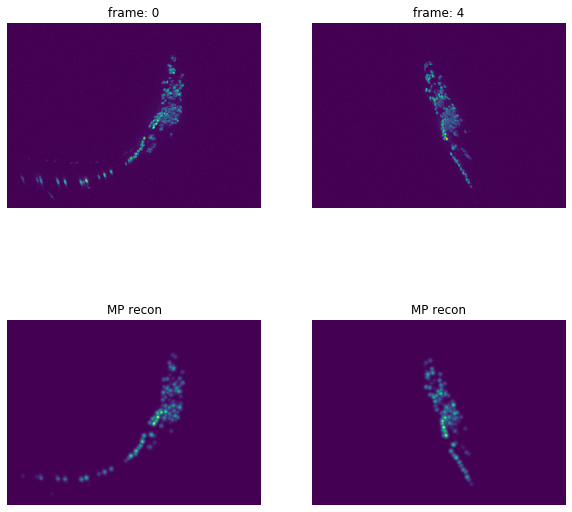

In [3]:
# Frames to load
t_start = 0
n_frames = 5
t_vals = range(t_start, t_start + n_frames)

# Load frames from dataset
img_path = '/home/mn2822/Desktop/WormOT/data/zimmer/raw/mCherry_v00065-00115.hdf5'
with io.ZimmerReader(img_path) as reader:
    units = reader.units
    img = [reader.get_frame(t) for t in t_vals]

# Load MP components
mp_path = '/home/mn2822/Desktop/WormOT/data/zimmer/mp_components/mp_0000_0050.h5'
with io.MPReader(mp_path) as reader:
    mps = [reader.get_frame(t) for t in t_vals]

# Reconstruct images from MPs
mp_img = [imagerep.reconstruct_mp_image(mp, units) for mp in mps]

# Indices to plot
k1 = 0
k2 = -1
  
plt.figure(figsize=(10, 10))

plt.subplot(221)
plot_maxproj_units(img[k1], units)
plt.title(f'frame: {t_vals[k1]}')
plt.axis('off')

plt.subplot(222)
plot_maxproj_units(img[k2], units)
plt.title(f'frame: {t_vals[k2]}')
plt.axis('off');

plt.subplot(223)
plot_maxproj_units(mp_img[k1], units)
plt.title('MP recon')
plt.axis('off')

plt.subplot(224)
plot_maxproj_units(mp_img[k2], units)
plt.title('MP recon')
plt.axis('off');

## Compute registrations for images

### Choose registration method

In [14]:
reg = partial(imagereg.ot_registration, degree=2, n_iter=300)

### Register all frames to first frame

In [15]:
models = [None] * (n_frames - 1)
debug = [None] * (n_frames - 1)

# Compute mapping from nth frame to first frame
for t in range(n_frames - 1):
    models[t], debug[t] = reg(mps[t + 1], mps[0])

### Reconstruct frames using mappings learned using both methods

In [16]:
rec = [mp_img[0]] + [None] * (n_frames - 1)

for t in range(1, n_frames):
    
    pb_pts = models[t - 1].predict(mps[t].pts)
    pb_mp = imagerep.ImageMP(pb_pts, mps[t].wts, mps[t].cov, mps[t].img_limits)
    rec[t] = imagerep.reconstruct_mp_image(pb_mp, units)

### Plot single frame next to reconstruction

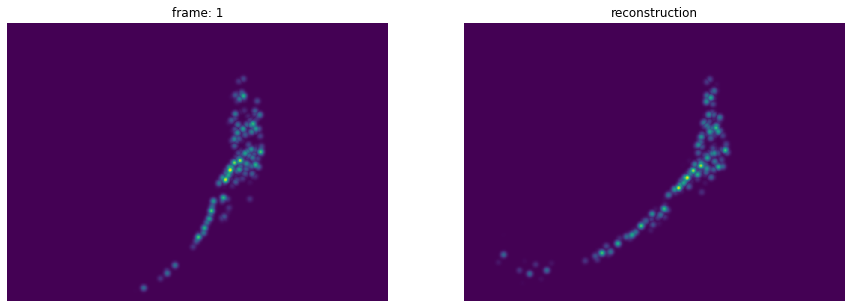

In [17]:
t = 1

plt.figure(figsize=(15, 15))

plt.subplot(121)
plot_maxproj_units(mp_img[t], units)
plt.title(f'frame: {t}')
plt.axis('off')
        
plt.subplot(122)
plot_maxproj_units(rec[t], units)
plt.title(f'reconstruction')
plt.axis('off');

### Create video of all frame reconstructions

In [18]:
fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(15, 15))

ax_1.set_title('frame: 0')
ax_2.set_title('straightened')

ax_1.axis('off')
ax_2.axis('off')

def animate(t):
    
    ax_1.set_title(f'frame: {t}')
    
    plot_maxproj_units(mp_img[t], units, ax=ax_1, animated=True)
    plot_maxproj_units(rec[t], units, ax=ax_2, animated=True)
    
ani = animation.FuncAnimation(fig, animate, n_frames)
#ani.save('video_straight_ot.mp4')

# Prevent double-display of animation
plt.close()

# Display animation in notebook
HTML(ani.to_html5_video())